In [2]:
import trimesh
import numpy as np
from rlr_audio_propagation import Config, Context, ChannelLayout, ChannelLayoutType
import matplotlib.pyplot as plt
import soundfile as sf

width, depth, height = 5.0, 5.0, 2.0 
vertices = np.array([
    [0, 0, 0], [width, 0, 0], [width, depth, 0], [0, depth, 0],
    [0, 0, height], [width, 0, height], [width, depth, height], [0, depth, height]
])
faces = np.array([
    [0, 1, 2], [0, 2, 3], [4, 5, 6], [4, 6, 7],
    [0, 4, 7], [0, 7, 3], [1, 5, 6], [1, 6, 2],
    [3, 2, 6], [3, 6, 7], [0, 1, 5], [0, 5, 4]
])

# Create microphone
sphere_radius = min(width, depth, height) / 32
sphere_center = [width/2, depth/2, height/2]
sphere_mesh = trimesh.creation.icosphere(radius=sphere_radius, subdivisions=3)
sphere_mesh.apply_translation(sphere_center)
sphere_mesh.visual.face_colors = [0, 0, 255, 255]

# Set up config with reverberation
cfg = Config()
cfg.indirect_ray_count = 50000 
cfg.indirect_ray_depth = 25  
cfg.source_ray_count = 50000 
cfg.source_ray_depth = 25 
cfg.max_diffraction_order = 1
cfg.direct_ray_count = 8000 
cfg.max_ir_length = 1.5 
cfg.mesh_simplification = False

ctx = Context(cfg)
ctx.add_object()
ctx.set_object_position(0, [0, 0, 0])
ctx.add_mesh_vertices(vertices.flatten().tolist())
ctx.add_mesh_indices(faces.flatten().tolist(), 3, "default")
ctx.finalize_object_mesh(0)

ctx.add_listener(ChannelLayout(ChannelLayoutType.Ambisonics, 4))
ctx.set_listener_position(0, sphere_center)

# make 5x5x5 grid of source positions, excluding center
grid_size = 5
x_positions = np.linspace(0.1 * width, 0.9 * width, grid_size)
y_positions = np.linspace(0.1 * depth, 0.9 * depth, grid_size)
z_positions = np.linspace(0.1 * height, 0.9 * height, grid_size)

source_positions = []
for x in x_positions:
    for y in y_positions:
        for z in z_positions:
            # Check that position is not the center
            if not np.allclose([x, y, z], sphere_center, atol=sphere_radius):
                source_positions.append([x, y, z])

box_mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
for i, position in enumerate(source_positions):
    ctx.add_source()
    ctx.set_source_position(i, position)
    
    source_sphere = trimesh.creation.icosphere(radius=sphere_radius, subdivisions=2)
    source_sphere.apply_translation(position)
    source_sphere.visual.face_colors = [0, 255, 0, 255]
    box_mesh = trimesh.util.concatenate([box_mesh, source_sphere])

combined_mesh = trimesh.util.concatenate([box_mesh, sphere_mesh])
print(f"Is the mesh watertight? {combined_mesh.is_watertight}")
combined_mesh.show()

Material for category 'default' was not found. Using default material instead.


Is the mesh watertight? True


Room Impulse Response saved as room_impulse_response.wav
Number of IR channels: 4
Number of IR samples: 11412
Sample rate: 44100 Hz


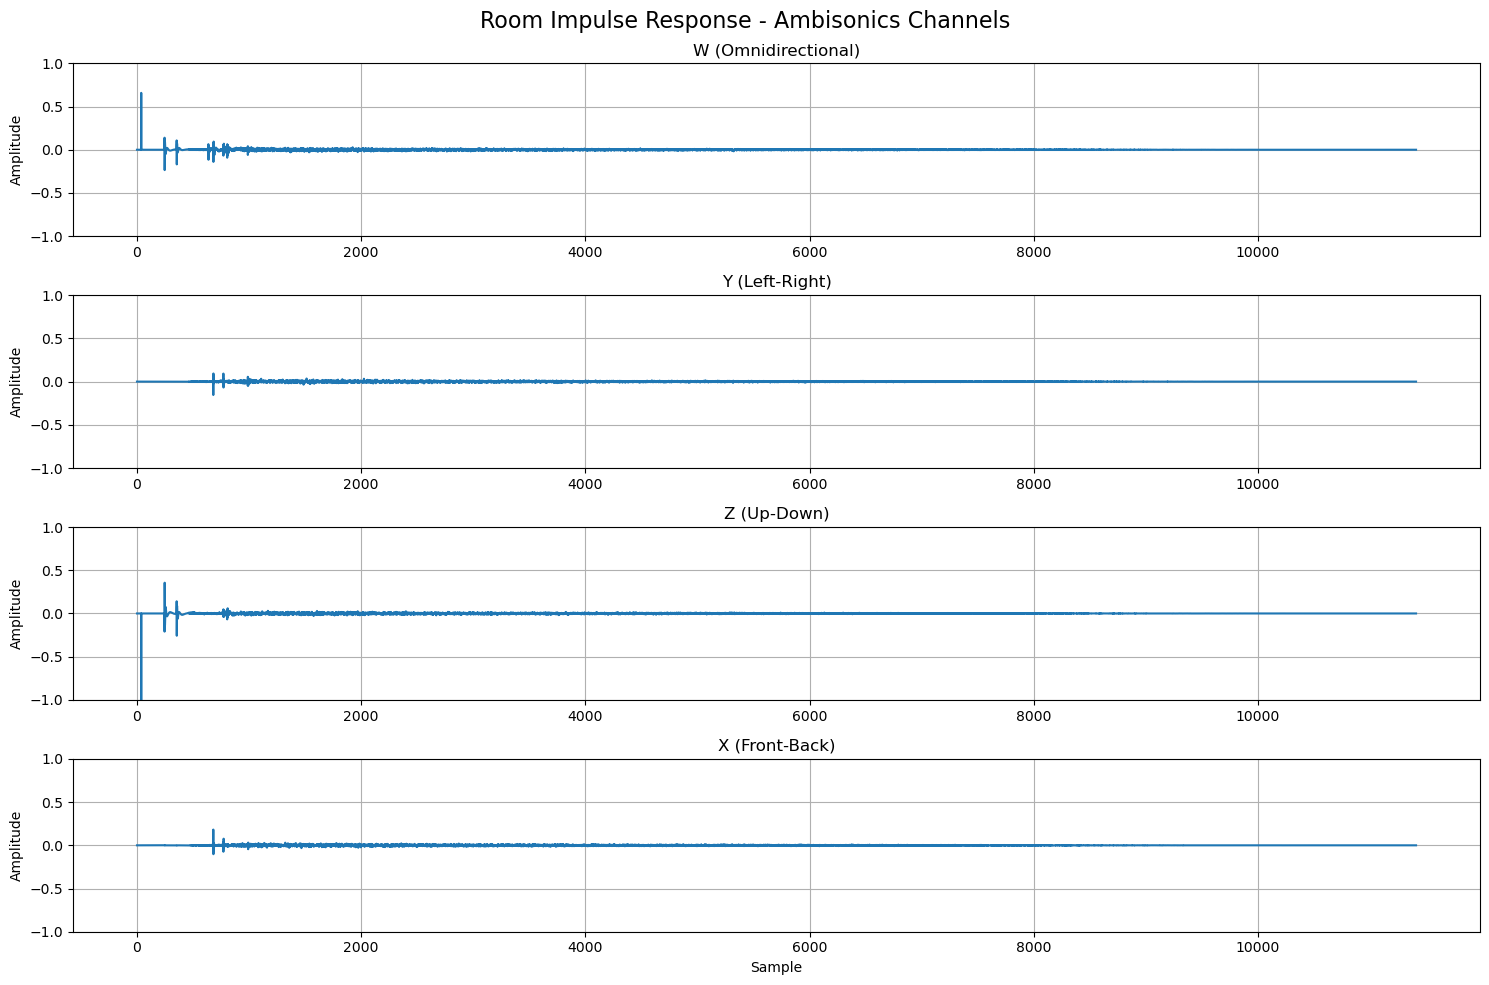

In [3]:
ctx.simulate()
output_filename = "room_impulse_response.wav"
listener_index = 0
source_index = 61

ir_sample_count = ctx.get_ir_sample_count(listener_index, source_index)
ir_channel_count = ctx.get_ir_channel_count(listener_index, source_index)
ir = np.zeros((ir_channel_count, ir_sample_count))
for i in range(ir_channel_count):
    channel = np.array(ctx.get_ir_channel(listener_index, source_index, i))
    ir[i] = channel

sample_rate = int(cfg.sample_rate) 
sf.write(output_filename, ir.T, sample_rate)

print(f"Room Impulse Response saved as {output_filename}")
print(f"Number of IR channels: {ir_channel_count}")
print(f"Number of IR samples: {ir_sample_count}")
print(f"Sample rate: {sample_rate} Hz")

plt.figure(figsize=(15, 10))
channel_names = ['W (Omnidirectional)', 'Y (Left-Right)', 'Z (Up-Down)', 'X (Front-Back)']
for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.plot(ir[i])
    plt.title(channel_names[i])
    plt.ylim([-1,1])
    plt.ylabel('Amplitude')
    plt.grid(True)
plt.xlabel('Sample')
plt.suptitle('Room Impulse Response - Ambisonics Channels', fontsize=16)
plt.tight_layout()
plt.show()

In [4]:
import os
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

wav_dir = "RIR_wavs"
png_dir = "RIR_plots"
os.makedirs(wav_dir, exist_ok=True)
os.makedirs(png_dir, exist_ok=True)

ctx.simulate()
listener_index = 0

for source_index, source_position in enumerate(source_positions):
    # Calculate relative position to the microphone
    relative_position = np.array(source_position) - np.array(sphere_center)
    x, y, z = relative_position
    x, y, z = round(x, 2), round(y, 2), round(z, 2)
    
    coord_filename = f"{x}_{y}_{z}"
    
    output_filename = os.path.join(wav_dir, f"{coord_filename}.wav")
    print(f"Source index {source_index} file name is: {coord_filename}.wav")
    
    ir_sample_count = ctx.get_ir_sample_count(listener_index, source_index)
    ir_channel_count = ctx.get_ir_channel_count(listener_index, source_index)
    ir = np.zeros((ir_channel_count, ir_sample_count))
    
    for i in range(ir_channel_count):
        channel = np.array(ctx.get_ir_channel(listener_index, source_index, i))
        ir[i] = channel
    
    sample_rate = int(cfg.sample_rate) 
    sf.write(output_filename, ir.T, sample_rate)
    
    print(f"Room Impulse Response saved as {output_filename}")
    print(f"Number of IR channels: {ir_channel_count}")
    print(f"Number of IR samples: {ir_sample_count}")
    print(f"Sample rate: {sample_rate} Hz")
    
    plt.figure(figsize=(15, 10))
    channel_names = ['W (Omnidirectional)', 'Z (Up-Down)', 'Y (Left-Right)', 'X (Front-Back)']
    for i in range(4):
        plt.subplot(4, 1, i+1)
        plt.plot(ir[i])
        plt.title(f"{channel_names[i]} - Source at ({x}, {y}, {z})")
        plt.ylim([-1,1])
        plt.ylabel('Amplitude')
        plt.grid(True)
    
    plt.xlabel('Sample')
    plt.suptitle(f'Room Impulse Response - Ambisonics Channels - Source at ({x}, {y}, {z})', fontsize=16)
    plt.tight_layout()
    plot_filename = os.path.join(png_dir, f"RIR_plot_{coord_filename}.png")
    plt.savefig(plot_filename)
    plt.close()

print("All Room Impulse Responses have been saved and plotted.")

Source index 0 file name is: -2.0_-2.0_-0.8.wav
Room Impulse Response saved as RIR_wavs/-2.0_-2.0_-0.8.wav
Number of IR channels: 4
Number of IR samples: 11485
Sample rate: 44100 Hz
Source index 1 file name is: -2.0_-2.0_-0.4.wav
Room Impulse Response saved as RIR_wavs/-2.0_-2.0_-0.4.wav
Number of IR channels: 4
Number of IR samples: 11419
Sample rate: 44100 Hz
Source index 2 file name is: -2.0_-2.0_0.0.wav
Room Impulse Response saved as RIR_wavs/-2.0_-2.0_0.0.wav
Number of IR channels: 4
Number of IR samples: 11371
Sample rate: 44100 Hz
Source index 3 file name is: -2.0_-2.0_0.4.wav
Room Impulse Response saved as RIR_wavs/-2.0_-2.0_0.4.wav
Number of IR channels: 4
Number of IR samples: 11376
Sample rate: 44100 Hz
Source index 4 file name is: -2.0_-2.0_0.8.wav
Room Impulse Response saved as RIR_wavs/-2.0_-2.0_0.8.wav
Number of IR channels: 4
Number of IR samples: 11385
Sample rate: 44100 Hz
Source index 5 file name is: -2.0_-1.0_-0.8.wav
Room Impulse Response saved as RIR_wavs/-2.0_-1.

In [6]:
!zip -r RIR_wavs.zip RIR_wavs

  adding: RIR_wavs/ (stored 0%)
  adding: RIR_wavs/1.0_1.0_-0.4.wav (deflated 39%)
  adding: RIR_wavs/-2.0_2.0_-0.8.wav (deflated 39%)
  adding: RIR_wavs/0.0_-2.0_-0.4.wav (deflated 39%)
  adding: RIR_wavs/-2.0_-1.0_-0.4.wav (deflated 38%)
  adding: RIR_wavs/0.0_0.0_0.4.wav (deflated 38%)
  adding: RIR_wavs/-1.0_0.0_0.0.wav (deflated 36%)
  adding: RIR_wavs/0.0_-2.0_0.8.wav (deflated 38%)
  adding: RIR_wavs/2.0_2.0_0.0.wav (deflated 40%)
  adding: RIR_wavs/1.0_2.0_0.8.wav (deflated 38%)
  adding: RIR_wavs/2.0_0.0_0.8.wav (deflated 38%)
  adding: RIR_wavs/-2.0_0.0_-0.8.wav (deflated 42%)
  adding: RIR_wavs/-2.0_1.0_-0.8.wav (deflated 38%)
  adding: RIR_wavs/1.0_1.0_0.4.wav (deflated 39%)
  adding: RIR_wavs/0.0_1.0_0.4.wav (deflated 38%)
  adding: RIR_wavs/-2.0_-1.0_0.8.wav (deflated 39%)
  adding: RIR_wavs/2.0_-2.0_0.0.wav (deflated 40%)
  adding: RIR_wavs/-2.0_-1.0_0.0.wav (deflated 40%)
  adding: RIR_wavs/1.0_0.0_0.4.wav (deflated 38%)
  adding: RIR_wavs/0.0_1.0_-0.8.wav (deflated 38%